런타임 > 런타임 유형 변경 > TPU 선택

In [1]:
pip install transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 32.1 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## 데이콘 - 훈련 및 검증 데이터

path = '/content/drive/MyDrive/NLI/open/'

origin_data = pd.read_csv(path + "train_data.csv")  #, sep='|', quoting=3)

In [5]:
origin_data ## (24998, 4)

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
24993,24993,"오페라에 비하여 오라토리오에서는 독창보다도 합창이 중시되며, 테스토 또는 이스토리쿠...",오라토리오에서 테스토의 역할이 가장 중요하다.,neutral
24994,24994,지하철역까지 걸어서 5분 정도 걸립니다.,지하철역까지 도보로 5분 정도 걸립니다.,entailment
24995,24995,한편 이날 중앙방역대책본부는 집단 감염이 발생한 음식점 관련 역학조사 결과를 공개했다.,중악방역대책본부는 집단 감염과 관련한 모든 정보를 비공개했다.,contradiction
24996,24996,마미손이 랩을 하자 시청자들은 그의 정체를 파악했다.,시청자들은 마미손의 정체를 안다.,entailment


In [6]:
test_data = pd.read_csv(path + "test_data.csv") #, sep='\t', quoting=3)

In [7]:
test_data ## (1666, 4)

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


## train, test 데이터 셔플링 하여 쪼개담기


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
test_data.head()

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer


In [9]:
def drop_na_and_duplciates(df):
  df = df.dropna()
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)
  return df

In [10]:
# 결측값 및 중복 샘플 제거
# train_data = drop_na_and_duplciates(train_data)
# val_data = drop_na_and_duplciates(val_data)

origin_data = drop_na_and_duplciates(origin_data)
test_data = drop_na_and_duplciates(test_data)

In [11]:
origin_data ## (24998, 4)

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
24993,24993,"오페라에 비하여 오라토리오에서는 독창보다도 합창이 중시되며, 테스토 또는 이스토리쿠...",오라토리오에서 테스토의 역할이 가장 중요하다.,neutral
24994,24994,지하철역까지 걸어서 5분 정도 걸립니다.,지하철역까지 도보로 5분 정도 걸립니다.,entailment
24995,24995,한편 이날 중앙방역대책본부는 집단 감염이 발생한 음식점 관련 역학조사 결과를 공개했다.,중악방역대책본부는 집단 감염과 관련한 모든 정보를 비공개했다.,contradiction
24996,24996,마미손이 랩을 하자 시청자들은 그의 정체를 파악했다.,시청자들은 마미손의 정체를 안다.,entailment


In [12]:
test_data ## (1666, 4)

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [13]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

# EDA (글자 길이 살펴보기)

샘플의 최대 길이 : 90
샘플의 평균 길이 : 45.406553


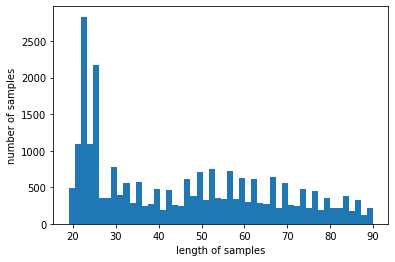

In [14]:
## 추가
import matplotlib.pyplot as plt


X_train = origin_data['premise'] ## 길이가 고르게 분포한 편이며, 가장 길 길이는 90 이하

print('샘플의 최대 길이 : %d' % max(len(l) for l in X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

샘플의 최대 길이 : 103
샘플의 평균 길이 : 24.924434


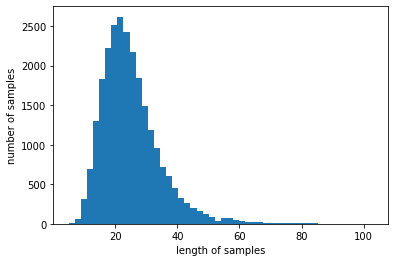

In [15]:
X_train = origin_data['hypothesis'] ## 길이가 20정도에서 분포가 가장 많고, 가장 길이가 긴 문장은 80조금 넘음.

print('샘플의 최대 길이 : %d' % max(len(l) for l in X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
print(origin_data['premise'][0])

print(len(origin_data['premise'][0]))

씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이 넓고 평평한 백사장이나 마당에서 모여 서로 힘과 슬기를 겨루는 것이다.
86


In [17]:
print(origin_data['hypothesis'][0])

print(len(origin_data['hypothesis'][0]))

씨름의 여자들의 놀이이다.
14


In [18]:
max_seq_len = 90 ## 변경해보기

In [19]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [20]:
from sklearn.model_selection import train_test_split


X = origin_data[['premise', 'hypothesis']]
y = origin_data['label']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(16748, 2) (8250, 2) (16748,) (8250,)


In [22]:
X_train.head()

,premise,hypothesis
12131,대산 수소연료전지 발전소는 부생 수소를 에너지원으로 활용한 세계 최초 상업용 발전소다.,부생 수소를 에너지원으로 활용하는 것은 복잡한 일이다.
12826,제2의 손기정을 꿈꾸는 마라토너 김준식과 일본 대표 마라토너 하세가와 타츠오는 날마...,김준식은 제2의 손기정을 꿈꾸는 마라토너이다.
2912,"주변에 망양정, 해월종택, 울진대게동상, 망양휴게소 전망대 등 관광지도 다양하게 있다.",관광지가 딱 한 곳만 있다.
22969,이에 따라 향후에도 협업인재들의 우수사례를 적극 홍보하고 전파해 협업문화가 확산되고...,협업인재들의 우수사례를 향후에도 적극 홍보할 것이다.
6369,크로스오버 작품은 원래 별개의 작품에 나오는 인물이 한 작품에 겹쳐 나오는 것을 가...,크로스오버 작품은 한 작품에 나오는 인물이 여러 작품에 계속 나오는 것을 말한다.


In [23]:
X_train = convert_examples_to_features(X_train['premise'], X_train['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/16748 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16748/16748 [00:14<00:00, 1193.12it/s]


In [24]:
X_train

(array([[    2, 24029,  9161, ...,     0,     0,     0],
        [    2,  1545,  2302, ...,     0,     0,     0],
        [    2,  4240,  2170, ...,     0,     0,     0],
        ...,
        [    2,  3995,  1408, ...,     0,     0,     0],
        [    2,  1891, 22992, ...,     0,     0,     0],
        [    2,  3660,  2299, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [25]:
# 최대 길이: 128
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    2 24029  9161 22791 13717  7246  2259  1173  2065  9161  2138 23071
  6233  3987  2470  3665  4418  6195  2048  7246  2062    18     3  1173
  2065  9161  2138 23071  6233  3987  2205  2259   575  2073  5629  2470
  1507 28674    18     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
세그먼트 인코딩 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
각 인코딩의 길이 : 90
정수 인코딩 복원 : [CLS] 대산 수소연료전지 발전소

In [26]:
X_val = convert_examples_to_features(X_val['premise'], X_val['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/8250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 8250/8250 [00:05<00:00, 1516.19it/s]


In [27]:
# 최대 길이: 128 -> 90
input_id = X_val[0][0]
attention_mask = X_val[1][0]
token_type_id = X_val[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    2 29670  3611  2031  2079  7798  2530  2170  3944  4143  2371 10283
    18     3 29670  2170  6791   831   543  2178  2088  1335 10283    18
     3     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
세그먼트 인코딩 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
각 인코딩의 길이 : 90
정수 인코딩 복원 : [CLS] 타이완 사람들의 친절함에

In [28]:
X_test = convert_examples_to_features(test_data['premise'], test_data['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/1666 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1666/1666 [00:01<00:00, 1512.79it/s]


In [29]:
test_data

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [30]:
type(y_train)

pandas.core.series.Series

In [31]:
train_label = y_train.tolist()
val_label = y_val.tolist()
test_label = test_data['label'].tolist()

In [32]:
print(len(train_label), len(val_label), len(test_label))

16748 8250 1666


In [33]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
y_val = idx_encode.transform(val_label) # 고유한 정수로 변환
###y_test = idx_encode.transform(test_label) # 고유한 정수로 변환
### y_test는 inference 할 값

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{'contradiction': 0, 'entailment': 1, 'neutral': 2}
{0: 'contradiction', 1: 'entailment', 2: 'neutral'}


In [34]:
from transformers import TFBertForSequenceClassification

In [35]:
# TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.37.82.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.37.82.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [36]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [37]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy'])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


524/524 [==============================] - 196s 198ms/step - loss: 0.6327 - accuracy: 0.7336 - val_loss: 0.4758 - val_accuracy: 0.8110
Epoch 2/20
524/524 [==============================] - 47s 89ms/step - loss: 0.3305 - accuracy: 0.8800 - val_loss: 0.4567 - val_accuracy: 0.8297
Epoch 3/20
524/524 [==============================] - 47s 89ms/step - loss: 0.1683 - accuracy: 0.9409 - val_loss: 0.5331 - val_accuracy: 0.8239
Epoch 4/20
524/524 [==============================] - 47s 89ms/step - loss: 0.1069 - accuracy: 0.9639 - val_loss: 0.6613 - val_accuracy: 0.8239


In [39]:
###print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, batch_size=1024)[1]))

## submit할 inference 분류 값 구하기

In [40]:
## idx_label: {0: 'contradiction', 1: 'entailment', 2: 'neutral'} 활용

In [41]:
X_test

(array([[    2,  4575,  4027, ...,     0,     0,     0],
        [    2,  3673,  4318, ...,     0,     0,     0],
        [    2, 23168,  2373, ...,     0,     0,     0],
        ...,
        [    2,  3647,  2125, ...,     0,     0,     0],
        [    2,  6335, 27135, ...,     0,     0,     0],
        [    2,   720,  3994, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [42]:
pred = model.predict(X_test)

print(pred)
print(type(pred))

TFSequenceClassifierOutput(loss=None, logits=array([[ 4.7280827, -1.7523803, -3.3664923],
       [-2.1562405, -1.4160352,  3.6938026],
       [-2.866417 , -2.0551074,  5.4148293],
       ...,
       [-2.1584492, -2.9102404,  5.461944 ],
       [-2.4786487, -2.3663073,  5.62459  ],
       [-2.7037954, -1.1536703,  3.46107  ]], dtype=float32), hidden_states=None, attentions=None)
<class 'transformers.modeling_tf_outputs.TFSequenceClassifierOutput'>


In [43]:
len(pred)

1

In [44]:
model.config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [45]:
X_test

(array([[    2,  4575,  4027, ...,     0,     0,     0],
        [    2,  3673,  4318, ...,     0,     0,     0],
        [    2, 23168,  2373, ...,     0,     0,     0],
        ...,
        [    2,  3647,  2125, ...,     0,     0,     0],
        [    2,  6335, 27135, ...,     0,     0,     0],
        [    2,   720,  3994, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [46]:
# X_test_tokens_new = {'input_ids': np.asarray(X_test_tokens['input_ids']),
#                      'token_type_ids': np.asarray(X_test_tokens['token_type_ids']),
#                      'attention_mask': np.asarray(X_test_tokens['attention_mask']),
#                      }



# from sklearn.metrics import confusion_matrix



pred_raw = model.predict(X_test)
##pred_proba = tf.nn.softmax(pred_raw).numpy()
pred = pred_raw[0].argmax(axis = 1)
# y_true = y_test.argmax(axis = 1)

# cm = confusion_matrix(y_true, pred)

In [47]:
print(pred)

[0 2 2 ... 2 2 2]


In [48]:
len(pred)

1666

In [49]:
answer_list = []


for i in range(len(pred)):
    answer_list.append(idx_label[pred[i]])


print(answer_list)

['contradiction', 'neutral', 'neutral', 'contradiction', 'contradiction', 'neutral', 'neutral', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'entailment', 'entailment', 'contradiction', 'neutral', 'entailment', 'entailment', 'contradiction', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'neutral', 'contradiction', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'entailment', 'entailment', 'neutral', 'neutral', 'contradiction', 'neutral', 'entailment', 'contradiction', 'entailment', 'neutral', 'contradiction', 'contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'entailment', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'neutral', 'neutral', 'contradiction', 'contradiction', 'entailment', 'neutral', 'entailment', 'contradiction', 'neutral', 'neutr

## submission.csv 양식에 맞게 파일 저장 !

In [50]:
submit = pd.read_csv(path + "sample_submission.csv")

In [51]:
submit

,index,label
0,0,answer
1,1,answer
2,2,answer
3,3,answer
4,4,answer
...,...,...
1661,1661,answer
1662,1662,answer
1663,1663,answer
1664,1664,answer


In [52]:
submit['label'] = answer_list

In [53]:
submit

,index,label
0,0,contradiction
1,1,neutral
2,2,neutral
3,3,contradiction
4,4,contradiction
...,...,...
1661,1661,neutral
1662,1662,neutral
1663,1663,neutral
1664,1664,neutral


In [54]:
submit.to_csv(path+"submit_02.csv", index=False, header = True)